# Inference pipeline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [3]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_post_00171.png'),
 PosixPath('data/test/images/test_pre_00064.png')]

In [4]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [5]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [6]:
len(preimgs), len(posimgs)

(933, 933)

In [7]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_pre_00064.png'),
 PosixPath('data/test/images/test_pre_00091.png')]

In [8]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00831.png'),
 PosixPath('data/test/images/test_post_00064.png'),
 PosixPath('data/test/images/test_post_00091.png')]

### Building detection

In [10]:
#seglearn = load_learner('./', file='building_detector.pkl', test=SegItemListCustom(preimgs), tfm_y=False)
seglearn = load_learner('./', file='sz1024_bs2_resnet34_8epochcycle_stage5.pkl')

In [11]:
#y_mask, pred_mask, raw_pred_mask = seglearn.get_preds(ds_type=DatasetType.Test)

In [48]:
idx = 117

#idx = 67 #all undamaged  
#idx = 34 #no features

In [49]:
img = open_image(preimgs[idx])
print(preimgs[idx])

data/test/images/test_pre_00290.png


In [50]:
%%time
y_mask, pred_mask, raw_pred_mask = seglearn.predict(img)

CPU times: user 632 ms, sys: 40 ms, total: 672 ms
Wall time: 336 ms


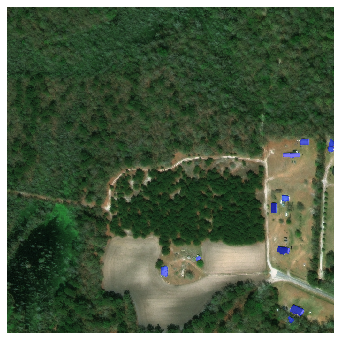

In [51]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
y_mask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Building mask -> polygons

In [52]:
_, polys = bmask2polys(y_mask.data[0].numpy())

In [53]:
type(polys), len(polys)

(numpy.ndarray, 12)

### Generate unique ids for polygons

In [54]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [55]:
uids = generate_uid_polys(polys)

### Get polygon images

In [56]:
path = Path('tmp_polyimgs')

In [57]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)

In [58]:
img = open_image(posimgs[idx])

In [59]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(path/f'{uid}.png')

Refactor into function.

In [60]:
#export
def polyimgs2disk(img, polys, path=None):
    if path is None: path = Path('tmp_polyimgs')
    shutil.rmtree(path, ignore_errors=True); os.makedirs(path, exist_ok=True)
    if len(polys) == 0: return path, []
    uids = generate_uid_polys(polys)
    for uid, p in zip(uids, polys): crop_by_polygon(img, p).save(path/f'{uid}.png')
    return path, uids

In [61]:
path, uids = polyimgs2disk(img, polys, path)

In [62]:
len(path.ls()), len(uids)

(12, 12)

### Damage classification

In [63]:
%%time
il = ImageList([path/f'{uid}.png' for uid in uids])
damglearn = load_learner('./', file='best_model_damg_nsample42000_sz299_bs32_resnet152.pkl', test=il)

CPU times: user 212 ms, sys: 140 ms, total: 352 ms
Wall time: 251 ms


In [64]:
len(il.items)

12

In [65]:
%%time
pred_damg, y_damg = damglearn.get_preds(ds_type=DatasetType.Test)

CPU times: user 116 ms, sys: 332 ms, total: 448 ms
Wall time: 591 ms


In [66]:
pred_classes = [damglearn.data.classes[i] for i in pred_damg.argmax(dim=1)]

In [67]:
pred_classes[3], pred_damg[3], y_damg[3], y_damg.sum()

('major', tensor([-3.4438,  1.8134,  5.3363, -0.1258]), tensor(0), tensor(0))

In [68]:
len(pred_classes), len(uids), len(polys), img

(12, 12, 12, Image (3, 1024, 1024))

Refactor into function.

In [71]:
#export
def assess_damage_polyimgs(polyimgs, path='./', file='stage2_last_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth.pkl'):
    if len(polyimgs.items) == 0: return [] # Need `.items` because `len(ImageList)` is 1 for empty list.
    damglearn = load_learner(path, file, test=polyimgs).to_fp32()
    pred_damg, _ = damglearn.get_preds(ds_type=DatasetType.Test)
    return [damglearn.data.classes[o] for o in pred_damg.argmax(dim=1)]

In [72]:
polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
damgs = assess_damage_polyimgs(polyimgs)

In [73]:
damgs[3], len(damgs)

('major', 12)

### Damage mask

In [74]:
CATS

['nun', 'minor', 'major', 'destroyed']

In [75]:
#export
DAMG_OTOI = {'nun':1, 'minor':2, 'major':3, 'destroyed':4}

In [76]:
damgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [77]:
for damg, poly in zip(damgs, polys):
    cv2.fillPoly(damgmask, poly[None,...], (DAMG_OTOI[damg]))
    
damgmask = ImageSegment(tensor(damgmask[None,...]))

Refactor into function.

In [78]:
#export
def damgpolys2damgmask(polys, damgs, sz=1024):
    assert len(polys) == len(damgs)
    if isinstance(sz, int): sz = (sz, sz)
    mask = np.zeros(sz, dtype=np.uint8)
    if len(polys) > 0:
        for damg, poly in zip(damgs, polys): 
            cv2.fillPoly(mask, poly[None,...], (DAMG_OTOI[damg]))
    return ImageSegment(tensor(mask[None,...]))

In [79]:
damgmask = damgpolys2damgmask(polys, damgs, img.shape[1:])

In [80]:
damgmask.data.unique()

tensor([0, 3])

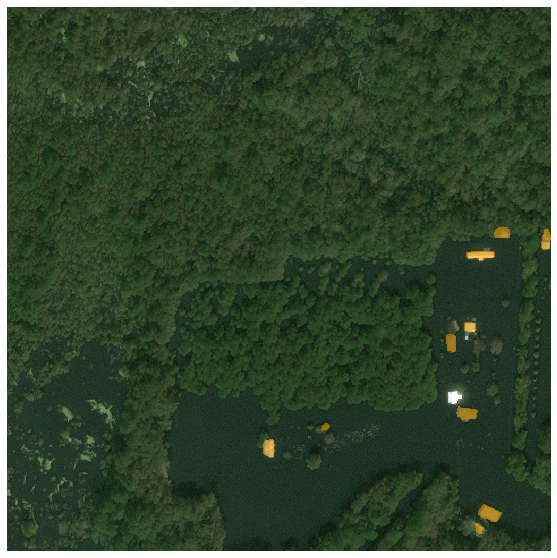

In [81]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
damgmask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Pipeline

In [82]:
#export
def infer_sample(path_preimg, path_posimg, seglearn, path_damglearn):
    img = open_image(path_preimg)
    y_mask, _, _ = seglearn.predict(img)
    _, polys = bmask2polys(y_mask.data[0].numpy())
    img = open_image(path_posimg)
    path, uids = polyimgs2disk(img, polys, path=Path('tmp_polyimgs'))
    polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
    damgs = assess_damage_polyimgs(polyimgs, file=path_damglearn)
    damgmask = damgpolys2damgmask(polys, damgs, sz=img.shape[1:])
    return damgmask

def get_imgid(imgname): return imgname.stem.split('_')[-1]

In [104]:
path_results = Path('./inference_results_stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth')

In [105]:
os.makedirs(path_results, exist_ok=True)

In [106]:
idx = 332
damgmask = infer_sample(preimgs[idx], posimgs[idx], seglearn, 'stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth.pkl')

tensor([0, 1, 3, 4])

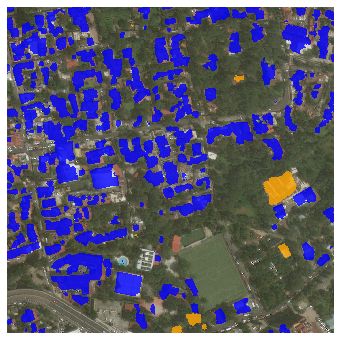

In [107]:
_, ax = plt.subplots(figsize=(6, 6))
open_image(posimgs[idx]).show(ax)
damgmask.show(ax, alpha=.8, cmap=CMAP, vmax=len(CMAP.colors)-1)
damgmask.data.unique()

Takes about 40 minutes to generate the inference .pngs for the entire test set.

In [135]:
path_damglearn = Path('best_model_damg_nsample94313_sz299_bs32_resnet152.pkl')
path_results = Path(f'./inference_results_{path_damglearn.stem}')
print(path_damglearn)
print(str(path_results))

best_model_damg_nsample94313_sz299_bs32_resnet152.pkl
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152


In [124]:
path_damglearn = Path('best_model_damg_nsample94313_sz299_bs32_resnet152.pkl')
path_results = Path(f'./inference_results_{path_damglearn.stem}')
os.makedirs(path_results, exist_ok=True)

for idx in tqdm.tqdm(range(len(preimgs))):
    npre, npos = preimgs[idx], posimgs[idx]
    damgmask = infer_sample(npre, npos, seglearn, path_damglearn)
    imgid = get_imgid(npre)
    damgmask.save(path_results/f'test_localization_{imgid}_prediction.png')
    damgmask.save(path_results/f'test_damage_{imgid}_prediction.png')

  0%|          | 0/933 [00:00<?, ?it/s]

  0%|          | 2/933 [00:02<19:11,  1.24s/it]

  0%|          | 3/933 [00:03<18:57,  1.22s/it]

  0%|          | 4/933 [00:05<24:40,  1.59s/it]

  1%|          | 5/933 [00:07<24:20,  1.57s/it]

  1%|          | 7/933 [00:10<21:44,  1.41s/it]

  1%|          | 8/933 [00:12<25:04,  1.63s/it]

  1%|          | 10/933 [00:14<20:43,  1.35s/it]

  1%|          | 11/933 [00:15<20:11,  1.31s/it]

  1%|▏         | 12/933 [00:18<26:47,  1.75s/it]

  2%|▏         | 15/933 [00:21<16:13,  1.06s/it]

  2%|▏         | 16/933 [00:22<18:23,  1.20s/it]

  2%|▏         | 18/933 [00:24<15:03,  1.01it/s]

  2%|▏         | 20/933 [00:26<13:44,  1.11it/s]

  2%|▏         | 21/933 [00:29<23:26,  1.54s/it]

  2%|▏         | 22/933 [00:31<26:13,  1.73s/it]

  2%|▏         | 23/933 [00:32<23:55,  1.58s/it]

  3%|▎         | 24/933 [00:33<23:18,  1.54s/it]

  3%|▎         | 25/933 [00:37<34:14,  2.26s/it]

  3%|▎         | 27/933 [00:40<25:53,  1.71s/it]

  3%|▎         | 29/933 [00:44<25:16,  1.68s/it]

  3%|▎         | 30/933 [00:47<31:41,  2.11s/it]

  3%|▎         | 31/933 [00:49<32:43,  2.18s/it]

  3%|▎         | 32/933 [00:51<31:30,  2.10s/it]

  4%|▎         | 34/933 [00:55<27:03,  1.81s/it]

  4%|▍         | 35/933 [00:56<24:24,  1.63s/it]

  4%|▍         | 36/933 [01:00<35:31,  2.38s/it]

  4%|▍         | 37/933 [01:02<31:10,  2.09s/it]

  4%|▍         | 38/933 [01:06<41:49,  2.80s/it]

  4%|▍         | 39/933 [01:07<34:58,  2.35s/it]

  4%|▍         | 40/933 [01:15<1:00:13,  4.05s/it]

  4%|▍         | 41/933 [01:18<53:52,  3.62s/it]  

  5%|▍         | 42/933 [01:23<58:27,  3.94s/it]

  5%|▍         | 44/933 [01:24<34:20,  2.32s/it]

  5%|▍         | 45/933 [01:26<29:52,  2.02s/it]

  5%|▌         | 47/933 [01:29<25:39,  1.74s/it]

  5%|▌         | 48/933 [01:34<39:59,  2.71s/it]

  5%|▌         | 49/933 [01:36<34:50,  2.36s/it]

  5%|▌         | 50/933 [01:37<31:10,  2.12s/it]

  5%|▌         | 51/933 [01:41<39:55,  2.72s/it]

  6%|▌         | 52/933 [01:43<35:35,  2.42s/it]

  6%|▌         | 53/933 [01:44<30:11,  2.06s/it]

  6%|▌         | 54/933 [01:47<35:18,  2.41s/it]

  6%|▌         | 55/933 [01:51<41:40,  2.85s/it]

  6%|▌         | 56/933 [01:53<36:50,  2.52s/it]

  6%|▌         | 57/933 [01:54<32:06,  2.20s/it]

  6%|▌         | 58/933 [01:56<28:03,  1.92s/it]

  6%|▋         | 59/933 [01:57<25:03,  1.72s/it]

  6%|▋         | 60/933 [01:58<23:09,  1.59s/it]

  7%|▋         | 61/933 [02:00<22:34,  1.55s/it]

  7%|▋         | 62/933 [02:01<22:03,  1.52s/it]

  7%|▋         | 65/933 [02:03<13:46,  1.05it/s]

  7%|▋         | 66/933 [02:05<16:07,  1.12s/it]

  7%|▋         | 67/933 [02:08<22:45,  1.58s/it]

  7%|▋         | 68/933 [02:13<39:13,  2.72s/it]

  8%|▊         | 70/933 [02:15<26:08,  1.82s/it]

  8%|▊         | 71/933 [02:16<23:54,  1.66s/it]

  8%|▊         | 72/933 [02:18<25:16,  1.76s/it]

  8%|▊         | 73/933 [02:20<24:32,  1.71s/it]

  8%|▊         | 74/933 [02:24<35:45,  2.50s/it]

  8%|▊         | 75/933 [02:26<31:11,  2.18s/it]

  8%|▊         | 76/933 [02:29<34:15,  2.40s/it]

  8%|▊         | 78/933 [02:31<23:31,  1.65s/it]

  8%|▊         | 79/933 [02:34<29:52,  2.10s/it]

  9%|▊         | 80/933 [02:37<35:13,  2.48s/it]

  9%|▊         | 81/933 [02:39<30:51,  2.17s/it]

  9%|▉         | 82/933 [02:40<26:57,  1.90s/it]

  9%|▉         | 83/933 [02:41<25:02,  1.77s/it]

  9%|▉         | 85/933 [02:43<17:43,  1.25s/it]

  9%|▉         | 86/933 [02:46<22:51,  1.62s/it]

  9%|▉         | 87/933 [02:47<21:16,  1.51s/it]

  9%|▉         | 88/933 [02:48<21:08,  1.50s/it]

 10%|▉         | 89/933 [02:50<20:47,  1.48s/it]

 10%|▉         | 90/933 [02:52<22:16,  1.59s/it]

 10%|▉         | 91/933 [02:54<24:29,  1.75s/it]

 10%|▉         | 92/933 [02:55<23:58,  1.71s/it]

 10%|▉         | 93/933 [02:57<22:33,  1.61s/it]

 10%|█         | 94/933 [02:58<21:29,  1.54s/it]

 10%|█         | 95/933 [03:00<24:44,  1.77s/it]

 10%|█         | 96/933 [03:04<32:04,  2.30s/it]

 10%|█         | 97/933 [03:05<29:09,  2.09s/it]

 11%|█         | 98/933 [03:08<29:15,  2.10s/it]

 11%|█         | 99/933 [03:10<32:24,  2.33s/it]

 11%|█         | 100/933 [03:12<28:59,  2.09s/it]

 11%|█         | 102/933 [03:14<19:46,  1.43s/it]

 11%|█         | 103/933 [03:15<20:16,  1.47s/it]

 11%|█         | 104/933 [03:16<19:10,  1.39s/it]

 11%|█▏        | 105/933 [03:20<29:05,  2.11s/it]

 11%|█▏        | 106/933 [03:22<25:26,  1.85s/it]

 12%|█▏        | 108/933 [03:24<21:29,  1.56s/it]

 12%|█▏        | 109/933 [03:26<20:54,  1.52s/it]

 12%|█▏        | 110/933 [03:33<43:13,  3.15s/it]

 12%|█▏        | 111/933 [03:37<48:54,  3.57s/it]

 12%|█▏        | 112/933 [03:39<40:13,  2.94s/it]

 12%|█▏        | 113/933 [03:40<33:17,  2.44s/it]

 12%|█▏        | 114/933 [03:47<50:49,  3.72s/it]

 12%|█▏        | 115/933 [03:50<46:58,  3.45s/it]

 12%|█▏        | 116/933 [03:51<37:42,  2.77s/it]

 13%|█▎        | 117/933 [03:53<33:28,  2.46s/it]

 13%|█▎        | 118/933 [03:54<29:03,  2.14s/it]

 13%|█▎        | 119/933 [03:56<26:44,  1.97s/it]

 13%|█▎        | 121/933 [03:58<19:17,  1.43s/it]

 13%|█▎        | 123/933 [03:59<15:00,  1.11s/it]

 13%|█▎        | 124/933 [04:01<16:25,  1.22s/it]

 14%|█▍        | 129/933 [04:05<09:22,  1.43it/s]

 14%|█▍        | 130/933 [04:12<36:53,  2.76s/it]

 14%|█▍        | 131/933 [04:16<41:51,  3.13s/it]

 14%|█▍        | 132/933 [04:26<1:06:02,  4.95s/it]

 14%|█▍        | 134/933 [04:29<41:29,  3.12s/it]  

 14%|█▍        | 135/933 [04:30<35:45,  2.69s/it]

 15%|█▍        | 136/933 [04:32<33:27,  2.52s/it]

 15%|█▍        | 137/933 [04:34<30:20,  2.29s/it]

 15%|█▍        | 139/933 [04:36<21:36,  1.63s/it]

 15%|█▌        | 140/933 [04:40<27:35,  2.09s/it]

 15%|█▌        | 141/933 [04:51<1:03:39,  4.82s/it]

 15%|█▌        | 142/933 [04:52<49:40,  3.77s/it]  

 15%|█▌        | 143/933 [05:00<1:03:58,  4.86s/it]

 15%|█▌        | 144/933 [05:05<1:04:49,  4.93s/it]

 16%|█▌        | 145/933 [05:06<50:58,  3.88s/it]  

 16%|█▌        | 146/933 [05:09<46:23,  3.54s/it]

 16%|█▌        | 147/933 [05:10<38:44,  2.96s/it]

 16%|█▌        | 148/933 [05:12<34:21,  2.63s/it]

 16%|█▌        | 149/933 [05:16<39:41,  3.04s/it]

 16%|█▌        | 150/933 [05:18<32:42,  2.51s/it]

 16%|█▌        | 151/933 [05:20<33:14,  2.55s/it]

 16%|█▋        | 152/933 [05:21<27:58,  2.15s/it]

 16%|█▋        | 153/933 [05:23<24:13,  1.86s/it]

 17%|█▋        | 155/933 [05:27<23:12,  1.79s/it]

 17%|█▋        | 156/933 [05:28<20:51,  1.61s/it]

 17%|█▋        | 157/933 [05:31<26:08,  2.02s/it]

 17%|█▋        | 161/933 [05:35<13:29,  1.05s/it]

 17%|█▋        | 162/933 [05:36<15:37,  1.22s/it]

 17%|█▋        | 163/933 [05:38<15:58,  1.25s/it]

 18%|█▊        | 164/933 [05:39<16:54,  1.32s/it]

 18%|█▊        | 165/933 [05:40<16:34,  1.30s/it]

 18%|█▊        | 167/933 [05:42<13:12,  1.03s/it]

 18%|█▊        | 168/933 [05:47<27:25,  2.15s/it]

 18%|█▊        | 169/933 [05:49<28:49,  2.26s/it]

 18%|█▊        | 170/933 [05:51<27:27,  2.16s/it]

 19%|█▊        | 173/933 [05:54<16:21,  1.29s/it]

 19%|█▊        | 174/933 [05:57<22:51,  1.81s/it]

 19%|█▉        | 175/933 [06:00<27:42,  2.19s/it]

 19%|█▉        | 176/933 [06:02<24:49,  1.97s/it]

 19%|█▉        | 177/933 [06:06<33:12,  2.64s/it]

 19%|█▉        | 178/933 [06:09<34:59,  2.78s/it]

 19%|█▉        | 179/933 [06:11<30:49,  2.45s/it]

 19%|█▉        | 181/933 [06:20<39:35,  3.16s/it]

 20%|█▉        | 182/933 [06:22<33:43,  2.70s/it]

 20%|█▉        | 184/933 [06:32<44:19,  3.55s/it]  

 20%|█▉        | 185/933 [06:33<35:50,  2.88s/it]

 20%|█▉        | 186/933 [06:37<39:11,  3.15s/it]

 20%|██        | 189/933 [06:40<19:07,  1.54s/it]

 20%|██        | 190/933 [06:41<18:32,  1.50s/it]

 20%|██        | 191/933 [06:43<20:00,  1.62s/it]

 21%|██        | 193/933 [06:45<15:51,  1.29s/it]

 21%|██        | 194/933 [06:48<21:52,  1.78s/it]

 21%|██        | 196/933 [06:52<20:58,  1.71s/it]

 21%|██        | 197/933 [06:53<19:40,  1.60s/it]

 21%|██        | 198/933 [06:54<18:12,  1.49s/it]

 21%|██▏       | 199/933 [06:56<19:09,  1.57s/it]

 21%|██▏       | 200/933 [06:57<18:13,  1.49s/it]

 22%|██▏       | 201/933 [07:00<20:35,  1.69s/it]

 22%|██▏       | 202/933 [07:04<29:45,  2.44s/it]

 22%|██▏       | 203/933 [07:05<25:49,  2.12s/it]

 22%|██▏       | 204/933 [07:06<22:31,  1.85s/it]

 22%|██▏       | 205/933 [07:08<20:14,  1.67s/it]

 22%|██▏       | 206/933 [07:09<19:39,  1.62s/it]

 22%|██▏       | 207/933 [07:11<20:14,  1.67s/it]

 22%|██▏       | 208/933 [07:12<19:43,  1.63s/it]

 23%|██▎       | 211/933 [07:18<17:42,  1.47s/it]

 23%|██▎       | 212/933 [07:19<17:08,  1.43s/it]

 23%|██▎       | 213/933 [07:21<16:29,  1.37s/it]

 23%|██▎       | 214/933 [07:22<17:18,  1.44s/it]

 23%|██▎       | 216/933 [07:24<13:06,  1.10s/it]

 23%|██▎       | 217/933 [07:25<14:04,  1.18s/it]

 23%|██▎       | 218/933 [07:34<39:55,  3.35s/it]

 24%|██▎       | 220/933 [07:36<25:32,  2.15s/it]

 24%|██▎       | 221/933 [07:39<27:21,  2.31s/it]

 24%|██▍       | 222/933 [07:40<23:25,  1.98s/it]

 24%|██▍       | 223/933 [07:41<21:23,  1.81s/it]

 24%|██▍       | 224/933 [07:45<28:20,  2.40s/it]

 24%|██▍       | 225/933 [07:46<24:25,  2.07s/it]

 24%|██▍       | 226/933 [07:49<28:33,  2.42s/it]

 24%|██▍       | 227/933 [07:51<25:02,  2.13s/it]

 24%|██▍       | 228/933 [07:55<32:36,  2.78s/it]

 25%|██▍       | 229/933 [07:56<27:14,  2.32s/it]

 25%|██▍       | 230/933 [07:58<25:50,  2.21s/it]

 25%|██▍       | 232/933 [08:00<18:01,  1.54s/it]

 25%|██▍       | 233/933 [08:02<18:24,  1.58s/it]

 25%|██▌       | 234/933 [08:04<20:36,  1.77s/it]

 25%|██▌       | 235/933 [08:05<18:29,  1.59s/it]

 25%|██▌       | 236/933 [08:08<20:44,  1.79s/it]

 25%|██▌       | 237/933 [08:09<18:48,  1.62s/it]

 26%|██▌       | 239/933 [08:12<16:36,  1.44s/it]

 26%|██▌       | 242/933 [08:16<13:16,  1.15s/it]

 26%|██▌       | 243/933 [08:19<21:37,  1.88s/it]

 26%|██▌       | 244/933 [08:20<19:14,  1.68s/it]

 26%|██▋       | 246/933 [08:25<20:42,  1.81s/it]

 26%|██▋       | 247/933 [08:28<24:06,  2.11s/it]

 27%|██▋       | 248/933 [08:35<41:12,  3.61s/it]

 27%|██▋       | 249/933 [08:36<33:20,  2.93s/it]

 27%|██▋       | 250/933 [08:40<38:02,  3.34s/it]

 27%|██▋       | 251/933 [08:42<30:46,  2.71s/it]

 27%|██▋       | 252/933 [08:43<25:39,  2.26s/it]

 27%|██▋       | 253/933 [08:46<28:59,  2.56s/it]

 27%|██▋       | 255/933 [08:48<19:01,  1.68s/it]

 27%|██▋       | 256/933 [08:52<28:29,  2.52s/it]

 28%|██▊       | 257/933 [08:57<35:09,  3.12s/it]

 28%|██▊       | 259/933 [09:01<25:57,  2.31s/it]

 28%|██▊       | 260/933 [09:02<22:53,  2.04s/it]

 28%|██▊       | 262/933 [09:04<16:01,  1.43s/it]

 28%|██▊       | 263/933 [09:05<16:41,  1.50s/it]

 28%|██▊       | 264/933 [09:07<16:28,  1.48s/it]

 28%|██▊       | 265/933 [09:08<16:02,  1.44s/it]

 29%|██▊       | 266/933 [09:11<20:54,  1.88s/it]

 29%|██▊       | 267/933 [09:12<18:39,  1.68s/it]

 29%|██▊       | 268/933 [09:14<17:49,  1.61s/it]

 29%|██▉       | 271/933 [09:18<13:23,  1.21s/it]

 29%|██▉       | 272/933 [09:19<13:33,  1.23s/it]

 29%|██▉       | 273/933 [09:22<20:45,  1.89s/it]

 29%|██▉       | 274/933 [09:25<21:48,  1.99s/it]

 30%|██▉       | 277/933 [09:27<11:55,  1.09s/it]

 30%|██▉       | 278/933 [09:32<26:43,  2.45s/it]

 30%|██▉       | 279/933 [09:35<26:43,  2.45s/it]

 30%|███       | 280/933 [09:36<22:48,  2.10s/it]

 30%|███       | 281/933 [09:42<36:11,  3.33s/it]

 30%|███       | 282/933 [09:45<33:04,  3.05s/it]

 30%|███       | 283/933 [09:47<31:38,  2.92s/it]

 30%|███       | 284/933 [09:50<30:52,  2.85s/it]

 31%|███       | 285/933 [09:54<33:22,  3.09s/it]

 31%|███       | 286/933 [09:56<31:50,  2.95s/it]

 31%|███       | 287/933 [10:00<33:48,  3.14s/it]

 31%|███       | 288/933 [10:01<29:06,  2.71s/it]

 31%|███       | 289/933 [10:08<40:12,  3.75s/it]

 31%|███       | 290/933 [10:09<32:33,  3.04s/it]

 31%|███       | 291/933 [10:13<36:03,  3.37s/it]

 31%|███▏      | 292/933 [10:16<33:08,  3.10s/it]

 31%|███▏      | 293/933 [10:18<29:04,  2.73s/it]

 32%|███▏      | 294/933 [10:19<24:47,  2.33s/it]

 32%|███▏      | 295/933 [10:20<22:23,  2.11s/it]

 32%|███▏      | 296/933 [10:29<41:52,  3.94s/it]

 32%|███▏      | 299/933 [10:34<23:20,  2.21s/it]

 32%|███▏      | 300/933 [10:37<25:59,  2.46s/it]

 32%|███▏      | 301/933 [10:38<22:49,  2.17s/it]

 32%|███▏      | 302/933 [10:40<21:00,  2.00s/it]

 32%|███▏      | 303/933 [10:48<40:29,  3.86s/it]

 33%|███▎      | 304/933 [10:52<39:37,  3.78s/it]

 33%|███▎      | 305/933 [10:53<32:09,  3.07s/it]

 33%|███▎      | 308/933 [11:00<22:50,  2.19s/it]

 33%|███▎      | 309/933 [11:02<19:49,  1.91s/it]

 33%|███▎      | 310/933 [11:06<26:42,  2.57s/it]

 33%|███▎      | 311/933 [11:10<32:28,  3.13s/it]

 33%|███▎      | 312/933 [11:12<27:35,  2.67s/it]

 34%|███▎      | 314/933 [11:15<21:29,  2.08s/it]

 34%|███▍      | 315/933 [11:17<19:17,  1.87s/it]

 34%|███▍      | 316/933 [11:21<26:46,  2.60s/it]

 34%|███▍      | 317/933 [11:26<33:07,  3.23s/it]

 34%|███▍      | 318/933 [11:30<35:31,  3.47s/it]

 34%|███▍      | 319/933 [11:31<28:42,  2.81s/it]

 34%|███▍      | 321/933 [11:35<22:34,  2.21s/it]

 35%|███▍      | 322/933 [11:38<25:15,  2.48s/it]

 35%|███▍      | 324/933 [11:45<27:05,  2.67s/it]

 35%|███▍      | 325/933 [11:46<23:06,  2.28s/it]

 35%|███▍      | 326/933 [11:49<24:51,  2.46s/it]

 35%|███▌      | 327/933 [11:50<21:26,  2.12s/it]

 35%|███▌      | 329/933 [11:52<14:22,  1.43s/it]

 35%|███▌      | 330/933 [11:53<15:02,  1.50s/it]

 35%|███▌      | 331/933 [11:55<14:21,  1.43s/it]

 36%|███▌      | 332/933 [11:56<13:50,  1.38s/it]

 36%|███▌      | 333/933 [12:03<30:05,  3.01s/it]

 36%|███▌      | 334/933 [12:05<26:51,  2.69s/it]

 36%|███▌      | 335/933 [12:10<33:49,  3.39s/it]

 36%|███▌      | 336/933 [12:11<27:31,  2.77s/it]

 36%|███▌      | 337/933 [12:14<27:07,  2.73s/it]

 36%|███▌      | 338/933 [12:17<27:42,  2.79s/it]

 36%|███▋      | 340/933 [12:19<18:16,  1.85s/it]

 37%|███▋      | 341/933 [12:20<16:38,  1.69s/it]

 37%|███▋      | 342/933 [12:24<24:37,  2.50s/it]

 37%|███▋      | 343/933 [12:26<21:09,  2.15s/it]

 37%|███▋      | 344/933 [12:27<18:41,  1.90s/it]

 37%|███▋      | 345/933 [12:29<20:03,  2.05s/it]

 37%|███▋      | 346/933 [12:31<18:27,  1.89s/it]

 37%|███▋      | 347/933 [12:32<17:05,  1.75s/it]

 37%|███▋      | 348/933 [12:34<16:13,  1.66s/it]

 37%|███▋      | 349/933 [12:38<23:58,  2.46s/it]

 38%|███▊      | 350/933 [12:40<23:22,  2.41s/it]

 38%|███▊      | 352/933 [12:42<15:29,  1.60s/it]

 38%|███▊      | 353/933 [12:45<17:56,  1.86s/it]

 38%|███▊      | 354/933 [12:46<16:46,  1.74s/it]

 38%|███▊      | 355/933 [12:48<17:37,  1.83s/it]

 38%|███▊      | 357/933 [12:52<15:41,  1.63s/it]

 38%|███▊      | 358/933 [12:56<22:49,  2.38s/it]

 38%|███▊      | 359/933 [12:57<19:29,  2.04s/it]

 39%|███▊      | 360/933 [12:59<18:19,  1.92s/it]

 39%|███▊      | 361/933 [13:00<16:51,  1.77s/it]

 39%|███▉      | 363/933 [13:02<12:49,  1.35s/it]

 39%|███▉      | 365/933 [13:04<10:42,  1.13s/it]

 39%|███▉      | 366/933 [13:08<17:36,  1.86s/it]

 39%|███▉      | 367/933 [13:09<17:12,  1.82s/it]

 39%|███▉      | 368/933 [13:11<16:11,  1.72s/it]

 40%|███▉      | 369/933 [13:12<14:47,  1.57s/it]

 40%|███▉      | 370/933 [13:13<14:03,  1.50s/it]

 40%|███▉      | 372/933 [13:21<22:38,  2.42s/it]

 40%|███▉      | 373/933 [13:23<19:10,  2.06s/it]

 40%|████      | 374/933 [13:24<18:56,  2.03s/it]

 40%|████      | 375/933 [13:27<20:27,  2.20s/it]

 40%|████      | 376/933 [13:33<29:48,  3.21s/it]

 40%|████      | 377/933 [13:37<32:04,  3.46s/it]

 41%|████      | 379/933 [13:40<22:53,  2.48s/it]

 41%|████      | 380/933 [13:42<19:33,  2.12s/it]

 41%|████      | 381/933 [13:43<18:57,  2.06s/it]

 41%|████      | 382/933 [13:45<17:04,  1.86s/it]

 41%|████      | 384/933 [13:47<12:54,  1.41s/it]

 41%|████▏     | 385/933 [13:48<12:40,  1.39s/it]

 41%|████▏     | 387/933 [13:50<10:35,  1.16s/it]

 42%|████▏     | 388/933 [13:55<18:49,  2.07s/it]

 42%|████▏     | 389/933 [13:56<16:56,  1.87s/it]

 42%|████▏     | 390/933 [13:59<19:58,  2.21s/it]

 42%|████▏     | 391/933 [14:01<19:11,  2.12s/it]

 42%|████▏     | 392/933 [14:07<30:18,  3.36s/it]

 42%|████▏     | 393/933 [14:10<29:04,  3.23s/it]

 42%|████▏     | 394/933 [14:13<26:59,  3.00s/it]

 43%|████▎     | 397/933 [14:15<13:13,  1.48s/it]

 43%|████▎     | 398/933 [14:16<12:36,  1.41s/it]

 43%|████▎     | 399/933 [14:18<12:07,  1.36s/it]

 43%|████▎     | 400/933 [14:19<12:14,  1.38s/it]

 43%|████▎     | 401/933 [14:20<12:28,  1.41s/it]

 43%|████▎     | 402/933 [14:22<12:17,  1.39s/it]

 43%|████▎     | 404/933 [14:24<10:39,  1.21s/it]

 44%|████▎     | 406/933 [14:28<12:00,  1.37s/it]

 44%|████▍     | 410/933 [14:30<06:47,  1.28it/s]

 44%|████▍     | 411/933 [14:32<08:04,  1.08it/s]

 44%|████▍     | 412/933 [14:33<09:02,  1.04s/it]

 44%|████▍     | 413/933 [14:37<16:32,  1.91s/it]

 44%|████▍     | 414/933 [14:39<16:48,  1.94s/it]

 44%|████▍     | 415/933 [14:40<15:37,  1.81s/it]

 45%|████▍     | 416/933 [14:43<16:41,  1.94s/it]

 45%|████▍     | 417/933 [14:46<19:27,  2.26s/it]

 45%|████▍     | 418/933 [14:49<21:04,  2.46s/it]

 45%|████▍     | 419/933 [14:50<19:03,  2.22s/it]

 45%|████▌     | 421/933 [14:56<19:12,  2.25s/it]

 45%|████▌     | 422/933 [14:57<17:21,  2.04s/it]

 45%|████▌     | 423/933 [15:01<21:20,  2.51s/it]

 46%|████▌     | 425/933 [15:06<19:27,  2.30s/it]

 46%|████▌     | 427/933 [15:08<14:30,  1.72s/it]

 46%|████▌     | 428/933 [15:11<17:41,  2.10s/it]

 46%|████▌     | 429/933 [15:14<18:17,  2.18s/it]

 46%|████▌     | 430/933 [15:17<19:57,  2.38s/it]

 46%|████▌     | 431/933 [15:18<16:58,  2.03s/it]

 46%|████▋     | 432/933 [15:19<15:19,  1.84s/it]

 46%|████▋     | 433/933 [15:20<14:05,  1.69s/it]

 47%|████▋     | 434/933 [15:22<13:54,  1.67s/it]

 47%|████▋     | 435/933 [15:25<17:36,  2.12s/it]

 47%|████▋     | 436/933 [15:27<15:41,  1.89s/it]

 47%|████▋     | 437/933 [15:28<13:57,  1.69s/it]

 47%|████▋     | 438/933 [15:30<14:34,  1.77s/it]

 47%|████▋     | 439/933 [15:34<20:28,  2.49s/it]

 47%|████▋     | 440/933 [15:36<19:03,  2.32s/it]

 47%|████▋     | 441/933 [15:37<16:14,  1.98s/it]

 47%|████▋     | 442/933 [15:39<14:53,  1.82s/it]

 47%|████▋     | 443/933 [15:40<13:33,  1.66s/it]

 48%|████▊     | 445/933 [15:44<14:16,  1.76s/it]

 48%|████▊     | 447/933 [15:46<10:08,  1.25s/it]

 48%|████▊     | 448/933 [15:47<10:25,  1.29s/it]

 48%|████▊     | 450/933 [15:49<08:17,  1.03s/it]

 48%|████▊     | 452/933 [15:51<08:32,  1.07s/it]

 49%|████▊     | 454/933 [15:53<07:43,  1.03it/s]

 49%|████▉     | 455/933 [15:55<08:48,  1.11s/it]

 49%|████▉     | 456/933 [15:56<09:16,  1.17s/it]

 49%|████▉     | 457/933 [16:02<19:47,  2.50s/it]

 49%|████▉     | 458/933 [16:09<30:31,  3.85s/it]

 49%|████▉     | 459/933 [16:12<29:00,  3.67s/it]

 49%|████▉     | 460/933 [16:15<28:01,  3.55s/it]

 50%|████▉     | 462/933 [16:19<20:05,  2.56s/it]

 50%|████▉     | 463/933 [16:21<18:28,  2.36s/it]

 50%|████▉     | 465/933 [16:26<18:06,  2.32s/it]

 50%|████▉     | 466/933 [16:32<25:40,  3.30s/it]

 50%|█████     | 467/933 [16:34<23:49,  3.07s/it]

 50%|█████     | 470/933 [16:36<11:29,  1.49s/it]

 50%|█████     | 471/933 [16:39<14:16,  1.85s/it]

 51%|█████     | 472/933 [16:41<14:55,  1.94s/it]

 51%|█████     | 473/933 [16:44<16:46,  2.19s/it]

 51%|█████     | 474/933 [16:46<14:59,  1.96s/it]

 51%|█████     | 475/933 [16:51<23:13,  3.04s/it]

 51%|█████     | 477/933 [16:58<22:49,  3.00s/it]

 51%|█████     | 478/933 [17:00<20:21,  2.68s/it]

 51%|█████▏    | 480/933 [17:02<12:56,  1.72s/it]

 52%|█████▏    | 481/933 [17:03<11:49,  1.57s/it]

 52%|█████▏    | 484/933 [17:05<07:24,  1.01it/s]

 52%|█████▏    | 485/933 [17:07<09:06,  1.22s/it]

 52%|█████▏    | 486/933 [17:09<09:31,  1.28s/it]

 52%|█████▏    | 487/933 [17:13<17:11,  2.31s/it]

 52%|█████▏    | 488/933 [17:15<15:29,  2.09s/it]

 52%|█████▏    | 489/933 [17:18<17:40,  2.39s/it]

 53%|█████▎    | 490/933 [17:19<15:10,  2.05s/it]

 53%|█████▎    | 491/933 [17:25<23:59,  3.26s/it]

 53%|█████▎    | 492/933 [17:28<22:16,  3.03s/it]

 53%|█████▎    | 493/933 [17:30<21:10,  2.89s/it]

 53%|█████▎    | 494/933 [17:34<23:37,  3.23s/it]

 53%|█████▎    | 495/933 [17:36<19:47,  2.71s/it]

 53%|█████▎    | 496/933 [17:37<16:59,  2.33s/it]

 53%|█████▎    | 497/933 [17:41<18:52,  2.60s/it]

 53%|█████▎    | 499/933 [17:42<12:04,  1.67s/it]

 54%|█████▎    | 500/933 [17:45<15:04,  2.09s/it]

 54%|█████▎    | 501/933 [17:47<13:28,  1.87s/it]

 54%|█████▍    | 502/933 [18:01<39:47,  5.54s/it]

 54%|█████▍    | 503/933 [18:09<45:58,  6.42s/it]

 54%|█████▍    | 504/933 [18:13<40:23,  5.65s/it]

 54%|█████▍    | 505/933 [18:18<38:50,  5.44s/it]

 54%|█████▍    | 507/933 [18:20<22:04,  3.11s/it]

 55%|█████▍    | 509/933 [18:22<13:36,  1.93s/it]

 55%|█████▍    | 510/933 [18:23<12:04,  1.71s/it]

 55%|█████▍    | 511/933 [18:24<11:43,  1.67s/it]

 55%|█████▍    | 512/933 [18:26<12:14,  1.74s/it]

 55%|█████▍    | 513/933 [18:28<11:59,  1.71s/it]

 55%|█████▌    | 514/933 [18:31<14:07,  2.02s/it]

 55%|█████▌    | 516/933 [18:33<09:58,  1.43s/it]

 55%|█████▌    | 517/933 [18:37<16:28,  2.38s/it]

 56%|█████▌    | 518/933 [18:39<14:06,  2.04s/it]

 56%|█████▌    | 519/933 [18:44<20:30,  2.97s/it]

 56%|█████▌    | 520/933 [18:45<17:11,  2.50s/it]

 56%|█████▌    | 521/933 [18:49<19:10,  2.79s/it]

 56%|█████▌    | 522/933 [18:52<20:38,  3.01s/it]

 56%|█████▌    | 523/933 [18:56<22:54,  3.35s/it]

 56%|█████▌    | 524/933 [19:01<26:18,  3.86s/it]

 56%|█████▋    | 525/933 [19:06<27:01,  3.97s/it]

 56%|█████▋    | 526/933 [19:09<25:42,  3.79s/it]

 56%|█████▋    | 527/933 [19:12<24:16,  3.59s/it]

 57%|█████▋    | 528/933 [19:15<22:11,  3.29s/it]

 57%|█████▋    | 529/933 [19:16<19:04,  2.83s/it]

 57%|█████▋    | 530/933 [19:18<16:43,  2.49s/it]

 57%|█████▋    | 532/933 [19:20<11:05,  1.66s/it]

 57%|█████▋    | 534/933 [19:23<10:16,  1.55s/it]

 58%|█████▊    | 537/933 [19:28<08:22,  1.27s/it]

 58%|█████▊    | 538/933 [19:29<08:32,  1.30s/it]

 58%|█████▊    | 539/933 [19:33<13:53,  2.11s/it]

 58%|█████▊    | 540/933 [19:34<12:37,  1.93s/it]

 58%|█████▊    | 541/933 [19:36<11:15,  1.72s/it]

 58%|█████▊    | 542/933 [19:37<10:35,  1.63s/it]

 58%|█████▊    | 543/933 [19:40<12:37,  1.94s/it]

 58%|█████▊    | 544/933 [19:41<11:13,  1.73s/it]

 58%|█████▊    | 545/933 [19:42<10:22,  1.60s/it]

 59%|█████▊    | 546/933 [19:44<09:59,  1.55s/it]

 59%|█████▉    | 549/933 [19:48<08:01,  1.26s/it]

 59%|█████▉    | 550/933 [19:50<10:08,  1.59s/it]

 59%|█████▉    | 551/933 [19:52<09:28,  1.49s/it]

 59%|█████▉    | 552/933 [19:53<09:30,  1.50s/it]

 59%|█████▉    | 554/933 [20:01<15:55,  2.52s/it]

 60%|█████▉    | 556/933 [20:04<11:11,  1.78s/it]

 60%|█████▉    | 557/933 [20:06<11:57,  1.91s/it]

 60%|█████▉    | 558/933 [20:10<15:03,  2.41s/it]

 60%|█████▉    | 559/933 [20:12<14:23,  2.31s/it]

 60%|██████    | 560/933 [20:13<12:43,  2.05s/it]

 60%|██████    | 561/933 [20:20<22:02,  3.56s/it]

 60%|██████    | 562/933 [20:22<17:46,  2.87s/it]

 60%|██████    | 563/933 [20:23<14:52,  2.41s/it]

 60%|██████    | 564/933 [20:26<15:51,  2.58s/it]

 61%|██████    | 566/933 [20:30<12:44,  2.08s/it]

 61%|██████    | 567/933 [20:31<11:12,  1.84s/it]

 61%|██████    | 570/933 [20:33<06:26,  1.06s/it]

 61%|██████    | 571/933 [20:34<06:49,  1.13s/it]

 61%|██████▏   | 572/933 [20:43<21:01,  3.49s/it]

 61%|██████▏   | 573/933 [20:45<16:59,  2.83s/it]

 62%|██████▏   | 574/933 [20:46<14:25,  2.41s/it]

 62%|██████▏   | 576/933 [20:49<11:04,  1.86s/it]

 62%|██████▏   | 577/933 [20:58<24:03,  4.05s/it]

 62%|██████▏   | 578/933 [21:01<21:38,  3.66s/it]

 62%|██████▏   | 579/933 [21:04<19:51,  3.36s/it]

 62%|██████▏   | 580/933 [21:08<21:54,  3.72s/it]

 62%|██████▏   | 581/933 [21:15<27:46,  4.73s/it]

 62%|██████▏   | 582/933 [21:18<23:18,  3.98s/it]

 63%|██████▎   | 585/933 [21:20<10:24,  1.79s/it]

 63%|██████▎   | 586/933 [21:23<11:54,  2.06s/it]

 63%|██████▎   | 587/933 [21:27<16:06,  2.79s/it]

 63%|██████▎   | 588/933 [21:35<24:28,  4.26s/it]

 63%|██████▎   | 589/933 [21:38<22:51,  3.99s/it]

 63%|██████▎   | 590/933 [21:39<18:13,  3.19s/it]

 63%|██████▎   | 591/933 [21:41<15:23,  2.70s/it]

 64%|██████▎   | 593/933 [21:45<11:54,  2.10s/it]

 64%|██████▎   | 594/933 [21:46<10:49,  1.92s/it]

 64%|██████▍   | 595/933 [21:47<09:46,  1.74s/it]

 64%|██████▍   | 597/933 [21:49<07:03,  1.26s/it]

 64%|██████▍   | 598/933 [21:55<14:52,  2.66s/it]

 64%|██████▍   | 599/933 [21:56<12:37,  2.27s/it]

 64%|██████▍   | 600/933 [22:00<14:29,  2.61s/it]

 64%|██████▍   | 601/933 [22:02<14:21,  2.60s/it]

 65%|██████▍   | 602/933 [22:05<15:03,  2.73s/it]

 65%|██████▍   | 603/933 [22:10<17:57,  3.26s/it]

 65%|██████▍   | 604/933 [22:11<14:34,  2.66s/it]

 65%|██████▍   | 606/933 [22:16<12:34,  2.31s/it]

 65%|██████▌   | 608/933 [22:18<08:43,  1.61s/it]

 65%|██████▌   | 610/933 [22:20<06:28,  1.20s/it]

 65%|██████▌   | 611/933 [22:22<07:56,  1.48s/it]

 66%|██████▌   | 612/933 [22:27<13:15,  2.48s/it]

 66%|██████▌   | 613/933 [22:28<11:17,  2.12s/it]

 66%|██████▌   | 615/933 [22:30<07:38,  1.44s/it]

 66%|██████▌   | 616/933 [22:31<07:41,  1.45s/it]

 66%|██████▌   | 617/933 [22:34<10:03,  1.91s/it]

 66%|██████▌   | 618/933 [22:37<11:54,  2.27s/it]

 66%|██████▋   | 619/933 [22:39<10:37,  2.03s/it]

 66%|██████▋   | 620/933 [22:41<10:32,  2.02s/it]

 67%|██████▋   | 622/933 [22:43<08:23,  1.62s/it]

 67%|██████▋   | 623/933 [22:48<13:32,  2.62s/it]

 67%|██████▋   | 624/933 [22:58<24:01,  4.66s/it]

 67%|██████▋   | 625/933 [23:01<21:29,  4.19s/it]

 67%|██████▋   | 626/933 [23:03<18:39,  3.65s/it]

 67%|██████▋   | 627/933 [23:06<17:23,  3.41s/it]

 67%|██████▋   | 628/933 [23:15<25:59,  5.11s/it]

 67%|██████▋   | 629/933 [23:17<20:21,  4.02s/it]

 68%|██████▊   | 631/933 [23:21<14:53,  2.96s/it]

 68%|██████▊   | 632/933 [23:23<13:45,  2.74s/it]

 68%|██████▊   | 633/933 [23:25<12:12,  2.44s/it]

 68%|██████▊   | 636/933 [23:28<06:28,  1.31s/it]

 68%|██████▊   | 638/933 [23:30<05:20,  1.09s/it]

 69%|██████▊   | 640/933 [23:31<04:26,  1.10it/s]

 69%|██████▉   | 642/933 [23:33<04:07,  1.18it/s]

 69%|██████▉   | 644/933 [23:36<04:53,  1.01s/it]

 69%|██████▉   | 645/933 [23:39<07:51,  1.64s/it]

 69%|██████▉   | 646/933 [23:40<07:31,  1.57s/it]

 69%|██████▉   | 647/933 [23:42<07:21,  1.54s/it]

 69%|██████▉   | 648/933 [23:43<07:14,  1.52s/it]

 70%|██████▉   | 649/933 [23:45<07:17,  1.54s/it]

 70%|██████▉   | 651/933 [23:47<06:03,  1.29s/it]

 70%|██████▉   | 653/933 [23:49<04:48,  1.03s/it]

 70%|███████   | 654/933 [23:50<05:14,  1.13s/it]

 70%|███████   | 655/933 [23:53<07:26,  1.61s/it]

 70%|███████   | 656/933 [23:54<07:15,  1.57s/it]

 70%|███████   | 657/933 [23:56<07:29,  1.63s/it]

 71%|███████   | 658/933 [24:06<18:51,  4.11s/it]

 71%|███████   | 660/933 [24:08<11:00,  2.42s/it]

 71%|███████   | 661/933 [24:10<10:14,  2.26s/it]

 71%|███████   | 663/933 [24:11<06:54,  1.54s/it]

 71%|███████   | 664/933 [24:15<09:28,  2.11s/it]

 71%|███████▏  | 665/933 [24:19<12:10,  2.73s/it]

 71%|███████▏  | 666/933 [24:23<14:22,  3.23s/it]

 72%|███████▏  | 668/933 [24:28<11:41,  2.65s/it]

 72%|███████▏  | 669/933 [24:30<10:01,  2.28s/it]

 72%|███████▏  | 670/933 [24:33<11:32,  2.63s/it]

 72%|███████▏  | 671/933 [24:38<14:07,  3.23s/it]

 72%|███████▏  | 672/933 [24:40<12:44,  2.93s/it]

 72%|███████▏  | 673/933 [24:47<17:39,  4.08s/it]

 72%|███████▏  | 675/933 [24:49<10:50,  2.52s/it]

 73%|███████▎  | 678/933 [24:51<05:32,  1.30s/it]

 73%|███████▎  | 679/933 [24:53<06:07,  1.45s/it]

 73%|███████▎  | 682/933 [24:57<04:39,  1.11s/it]

 73%|███████▎  | 684/933 [25:01<05:59,  1.44s/it]

 73%|███████▎  | 685/933 [25:03<06:48,  1.65s/it]

 74%|███████▎  | 687/933 [25:06<06:27,  1.57s/it]

 74%|███████▎  | 688/933 [25:08<06:54,  1.69s/it]

 74%|███████▍  | 689/933 [25:12<09:09,  2.25s/it]

 74%|███████▍  | 690/933 [25:14<08:35,  2.12s/it]

 74%|███████▍  | 691/933 [25:29<24:00,  5.95s/it]

 74%|███████▍  | 692/933 [25:30<18:37,  4.63s/it]

 74%|███████▍  | 694/933 [25:33<11:21,  2.85s/it]

 74%|███████▍  | 695/933 [25:42<18:37,  4.69s/it]

 75%|███████▍  | 696/933 [25:45<16:17,  4.13s/it]

 75%|███████▍  | 697/933 [25:46<12:53,  3.28s/it]

 75%|███████▍  | 698/933 [25:47<10:35,  2.71s/it]

 75%|███████▌  | 701/933 [25:50<05:19,  1.38s/it]

 75%|███████▌  | 703/933 [25:52<04:42,  1.23s/it]

 75%|███████▌  | 704/933 [25:55<06:33,  1.72s/it]

 76%|███████▌  | 705/933 [25:57<06:56,  1.83s/it]

 76%|███████▌  | 706/933 [26:00<07:57,  2.10s/it]

 76%|███████▌  | 711/933 [26:04<03:10,  1.17it/s]

 76%|███████▋  | 712/933 [26:05<03:35,  1.03it/s]

 77%|███████▋  | 714/933 [26:09<04:40,  1.28s/it]

 77%|███████▋  | 715/933 [26:12<07:02,  1.94s/it]

 77%|███████▋  | 716/933 [26:14<07:31,  2.08s/it]

 77%|███████▋  | 717/933 [26:17<08:23,  2.33s/it]

 77%|███████▋  | 718/933 [26:19<07:10,  2.00s/it]

 77%|███████▋  | 721/933 [26:21<04:01,  1.14s/it]

 77%|███████▋  | 722/933 [26:23<04:54,  1.39s/it]

 78%|███████▊  | 724/933 [26:25<04:12,  1.21s/it]

 78%|███████▊  | 725/933 [26:27<04:13,  1.22s/it]

 78%|███████▊  | 728/933 [26:29<02:55,  1.17it/s]

 78%|███████▊  | 729/933 [26:32<04:43,  1.39s/it]

 78%|███████▊  | 730/933 [26:34<05:19,  1.57s/it]

 78%|███████▊  | 731/933 [26:35<05:00,  1.49s/it]

 78%|███████▊  | 732/933 [26:37<05:14,  1.56s/it]

 79%|███████▊  | 733/933 [26:45<11:38,  3.49s/it]

 79%|███████▉  | 736/933 [26:48<05:43,  1.74s/it]

 79%|███████▉  | 737/933 [26:49<05:10,  1.59s/it]

 79%|███████▉  | 738/933 [26:52<06:29,  2.00s/it]

 79%|███████▉  | 739/933 [26:53<05:54,  1.83s/it]

 79%|███████▉  | 740/933 [26:55<05:35,  1.74s/it]

 79%|███████▉  | 741/933 [27:02<10:30,  3.28s/it]

 80%|███████▉  | 743/933 [27:04<06:31,  2.06s/it]

 80%|███████▉  | 744/933 [27:05<05:54,  1.88s/it]

 80%|███████▉  | 745/933 [27:06<05:19,  1.70s/it]

 80%|████████  | 748/933 [27:09<03:09,  1.03s/it]

 80%|████████  | 749/933 [27:10<03:19,  1.09s/it]

 80%|████████  | 750/933 [27:12<03:50,  1.26s/it]

 80%|████████  | 751/933 [27:13<03:51,  1.27s/it]

 81%|████████  | 753/933 [27:16<03:58,  1.32s/it]

 81%|████████  | 755/933 [27:19<03:36,  1.22s/it]

 81%|████████  | 758/933 [27:21<02:31,  1.15it/s]

 81%|████████▏ | 759/933 [27:22<02:59,  1.03s/it]

 81%|████████▏ | 760/933 [27:24<03:28,  1.20s/it]

 82%|████████▏ | 761/933 [27:26<03:51,  1.35s/it]

 82%|████████▏ | 763/933 [27:28<03:10,  1.12s/it]

 82%|████████▏ | 764/933 [27:30<03:46,  1.34s/it]

 82%|████████▏ | 765/933 [27:32<04:58,  1.78s/it]

 82%|████████▏ | 768/933 [27:34<02:49,  1.03s/it]

 83%|████████▎ | 770/933 [27:38<03:26,  1.27s/it]

 83%|████████▎ | 772/933 [27:42<03:58,  1.48s/it]

 83%|████████▎ | 773/933 [27:44<04:30,  1.69s/it]

 83%|████████▎ | 774/933 [27:45<04:05,  1.55s/it]

 83%|████████▎ | 775/933 [27:50<06:55,  2.63s/it]

 83%|████████▎ | 776/933 [27:53<06:47,  2.60s/it]

 83%|████████▎ | 777/933 [27:55<06:21,  2.45s/it]

 83%|████████▎ | 778/933 [27:56<05:29,  2.12s/it]

 83%|████████▎ | 779/933 [28:00<06:31,  2.54s/it]

 84%|████████▎ | 780/933 [28:01<05:42,  2.24s/it]

 84%|████████▍ | 783/933 [28:08<04:26,  1.78s/it]

 84%|████████▍ | 784/933 [28:09<04:00,  1.61s/it]

 84%|████████▍ | 785/933 [28:10<03:43,  1.51s/it]

 84%|████████▍ | 786/933 [28:15<05:55,  2.42s/it]

 84%|████████▍ | 787/933 [28:19<07:29,  3.08s/it]

 84%|████████▍ | 788/933 [28:21<06:11,  2.56s/it]

 85%|████████▍ | 790/933 [28:22<03:54,  1.64s/it]

 85%|████████▍ | 791/933 [28:25<04:52,  2.06s/it]

 85%|████████▍ | 792/933 [28:28<05:14,  2.23s/it]

 85%|████████▍ | 793/933 [28:29<04:39,  2.00s/it]

 85%|████████▌ | 794/933 [28:32<05:01,  2.17s/it]

 85%|████████▌ | 795/933 [28:36<06:19,  2.75s/it]

 85%|████████▌ | 796/933 [28:38<05:35,  2.45s/it]

 86%|████████▌ | 798/933 [28:46<06:52,  3.06s/it]

 86%|████████▌ | 799/933 [28:48<05:36,  2.51s/it]

 86%|████████▌ | 800/933 [28:50<05:15,  2.37s/it]

 86%|████████▌ | 801/933 [28:51<04:35,  2.09s/it]

 86%|████████▌ | 802/933 [28:53<04:11,  1.92s/it]

 86%|████████▌ | 803/933 [28:54<03:46,  1.74s/it]

 86%|████████▌ | 804/933 [28:55<03:29,  1.62s/it]

 86%|████████▋ | 805/933 [28:57<03:45,  1.76s/it]

 86%|████████▋ | 806/933 [28:59<03:30,  1.66s/it]

 86%|████████▋ | 807/933 [29:00<03:23,  1.62s/it]

 87%|████████▋ | 808/933 [29:03<03:46,  1.81s/it]

 87%|████████▋ | 810/933 [29:04<02:38,  1.29s/it]

 87%|████████▋ | 811/933 [29:06<02:35,  1.28s/it]

 87%|████████▋ | 812/933 [29:09<03:42,  1.84s/it]

 87%|████████▋ | 813/933 [29:10<03:27,  1.73s/it]

 87%|████████▋ | 814/933 [29:11<03:07,  1.57s/it]

 87%|████████▋ | 815/933 [29:19<06:31,  3.32s/it]

 87%|████████▋ | 816/933 [29:21<05:52,  3.01s/it]

 88%|████████▊ | 817/933 [29:22<04:47,  2.48s/it]

 88%|████████▊ | 818/933 [29:24<04:04,  2.12s/it]

 88%|████████▊ | 819/933 [29:27<04:27,  2.35s/it]

 88%|████████▊ | 820/933 [29:29<04:30,  2.39s/it]

 88%|████████▊ | 825/933 [29:33<01:36,  1.11it/s]

 89%|████████▊ | 826/933 [29:39<04:15,  2.39s/it]

 89%|████████▊ | 828/933 [29:42<03:13,  1.84s/it]

 89%|████████▉ | 829/933 [29:43<03:02,  1.75s/it]

 89%|████████▉ | 830/933 [29:46<03:18,  1.93s/it]

 89%|████████▉ | 831/933 [29:50<04:18,  2.54s/it]

 89%|████████▉ | 833/933 [29:53<03:18,  1.98s/it]

 89%|████████▉ | 835/933 [29:57<03:09,  1.94s/it]

 90%|████████▉ | 836/933 [30:01<03:56,  2.44s/it]

 90%|████████▉ | 837/933 [30:02<03:23,  2.12s/it]

 90%|████████▉ | 838/933 [30:04<02:53,  1.83s/it]

 90%|████████▉ | 839/933 [30:05<02:39,  1.69s/it]

 90%|█████████ | 840/933 [30:07<02:53,  1.86s/it]

 90%|█████████ | 841/933 [30:10<03:07,  2.03s/it]

 90%|█████████ | 842/933 [30:12<03:22,  2.23s/it]

 90%|█████████ | 843/933 [30:14<03:09,  2.11s/it]

 90%|█████████ | 844/933 [30:15<02:46,  1.87s/it]

 91%|█████████ | 845/933 [30:17<02:38,  1.80s/it]

 91%|█████████ | 846/933 [30:18<02:20,  1.62s/it]

 91%|█████████ | 847/933 [30:25<04:37,  3.22s/it]

 91%|█████████ | 849/933 [30:27<02:47,  1.99s/it]

 91%|█████████ | 850/933 [30:30<03:18,  2.40s/it]

 91%|█████████ | 851/933 [30:32<02:53,  2.11s/it]

 91%|█████████▏| 852/933 [30:35<03:14,  2.41s/it]

 91%|█████████▏| 853/933 [30:37<03:06,  2.33s/it]

 92%|█████████▏| 854/933 [30:40<03:26,  2.62s/it]

 92%|█████████▏| 855/933 [30:45<04:09,  3.20s/it]

 92%|█████████▏| 856/933 [30:48<04:04,  3.17s/it]

 92%|█████████▏| 859/933 [30:51<01:54,  1.55s/it]

 92%|█████████▏| 860/933 [30:52<01:49,  1.50s/it]

 92%|█████████▏| 861/933 [30:54<01:53,  1.58s/it]

 92%|█████████▏| 862/933 [31:04<04:47,  4.06s/it]

 92%|█████████▏| 863/933 [31:06<04:20,  3.72s/it]

 93%|█████████▎| 864/933 [31:09<04:00,  3.48s/it]

 93%|█████████▎| 866/933 [31:13<02:41,  2.41s/it]

 93%|█████████▎| 868/933 [31:16<02:00,  1.85s/it]

 93%|█████████▎| 869/933 [31:22<03:25,  3.21s/it]

 93%|█████████▎| 870/933 [31:27<03:48,  3.62s/it]

 93%|█████████▎| 871/933 [31:28<03:04,  2.98s/it]

 94%|█████████▎| 873/933 [31:31<02:06,  2.10s/it]

 94%|█████████▎| 874/933 [31:38<03:27,  3.52s/it]

 94%|█████████▍| 875/933 [31:39<02:45,  2.85s/it]

 94%|█████████▍| 876/933 [31:42<02:37,  2.76s/it]

 94%|█████████▍| 878/933 [31:44<01:42,  1.86s/it]

 94%|█████████▍| 880/933 [31:48<01:40,  1.90s/it]

 94%|█████████▍| 881/933 [31:53<02:16,  2.63s/it]

 95%|█████████▍| 882/933 [31:58<02:53,  3.40s/it]

 95%|█████████▍| 883/933 [31:59<02:17,  2.76s/it]

 95%|█████████▍| 884/933 [32:00<01:54,  2.34s/it]

 95%|█████████▍| 885/933 [32:02<01:35,  2.00s/it]

 95%|█████████▍| 886/933 [32:05<01:59,  2.54s/it]

 95%|█████████▌| 887/933 [32:09<02:14,  2.92s/it]

 95%|█████████▌| 888/933 [32:10<01:49,  2.43s/it]

 95%|█████████▌| 889/933 [32:12<01:31,  2.09s/it]

 95%|█████████▌| 890/933 [32:15<01:44,  2.43s/it]

 96%|█████████▌| 894/933 [32:18<00:39,  1.02s/it]

 96%|█████████▌| 896/933 [32:22<00:50,  1.37s/it]

 96%|█████████▌| 897/933 [32:23<00:47,  1.33s/it]

 96%|█████████▌| 898/933 [32:26<01:02,  1.79s/it]

 96%|█████████▋| 899/933 [32:31<01:32,  2.73s/it]

 96%|█████████▋| 900/933 [32:32<01:20,  2.44s/it]

 97%|█████████▋| 901/933 [32:34<01:06,  2.08s/it]

 97%|█████████▋| 902/933 [32:37<01:14,  2.40s/it]

 97%|█████████▋| 903/933 [32:38<01:00,  2.03s/it]

 97%|█████████▋| 904/933 [32:46<01:49,  3.78s/it]

 97%|█████████▋| 905/933 [32:49<01:42,  3.67s/it]

 97%|█████████▋| 906/933 [32:52<01:29,  3.32s/it]

 97%|█████████▋| 907/933 [32:53<01:10,  2.71s/it]

 97%|█████████▋| 908/933 [32:54<00:57,  2.30s/it]

 98%|█████████▊| 910/933 [32:56<00:34,  1.52s/it]

 98%|█████████▊| 912/933 [32:58<00:24,  1.17s/it]

 98%|█████████▊| 913/933 [33:00<00:29,  1.50s/it]

 98%|█████████▊| 914/933 [33:03<00:35,  1.89s/it]

 98%|█████████▊| 915/933 [33:05<00:37,  2.06s/it]

 98%|█████████▊| 917/933 [33:07<00:22,  1.41s/it]

 98%|█████████▊| 919/933 [33:11<00:21,  1.51s/it]

 99%|█████████▊| 921/933 [33:15<00:20,  1.68s/it]

 99%|█████████▉| 923/933 [33:17<00:12,  1.27s/it]

 99%|█████████▉| 924/933 [33:20<00:16,  1.86s/it]

 99%|█████████▉| 925/933 [33:24<00:19,  2.46s/it]

 99%|█████████▉| 926/933 [33:26<00:16,  2.30s/it]

 99%|█████████▉| 927/933 [33:29<00:14,  2.46s/it]

 99%|█████████▉| 928/933 [33:30<00:10,  2.10s/it]

100%|█████████▉| 930/933 [33:32<00:04,  1.46s/it]

100%|█████████▉| 932/933 [33:35<00:01,  1.42s/it]

100%|██████████| 933/933 [33:36<00:00,  2.16s/it]


### Load a few saved submission png files

In [125]:
print(len(get_image_files(path_results)))
get_image_files(path_results)[:5]

1866


[PosixPath('inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00536_prediction.png'),
 PosixPath('inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00313_prediction.png'),
 PosixPath('inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00142_prediction.png'),
 PosixPath('inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00376_prediction.png'),
 PosixPath('inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00919_prediction.png')]

In [126]:
#imgid = get_imgid(preimgs[117])
imgid = get_imgid(preimgs[332]) #Lots of buildings [0, 1, 3, 4]
# imgid = '00064'  no buildings

In [127]:
path_local = path_results/f'test_localization_{imgid}_prediction.png'
path_damg = path_results/f'test_damage_{imgid}_prediction.png'

In [128]:
np.unique(PIL.Image.open(path_damg))

array([0, 1, 2, 3, 4], dtype=uint8)

In [129]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

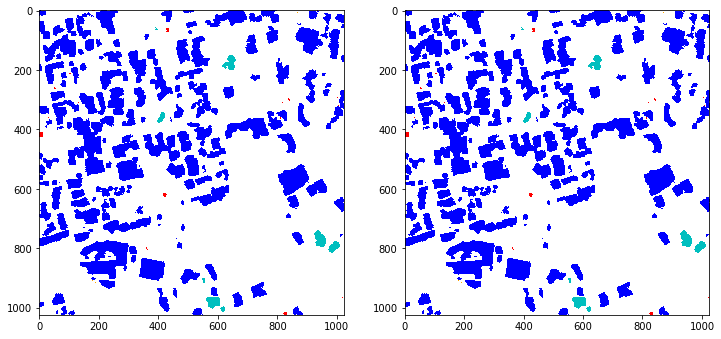

In [130]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 15))
axs[0].imshow(np.array(PIL.Image.open(path_local)), cmap=CMAP, vmin=0, vmax=4)
axs[1].imshow(np.array(PIL.Image.open(path_damg)), cmap=CMAP, vmin=0, vmax=4);

In [131]:
mask_local, mask_damg = open_mask(path_local), open_mask(path_damg)

In [132]:
mask_local.data.unique(), mask_damg.data.unique()

(tensor([0, 1, 2, 3, 4]), tensor([0, 1, 2, 3, 4]))

In [133]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

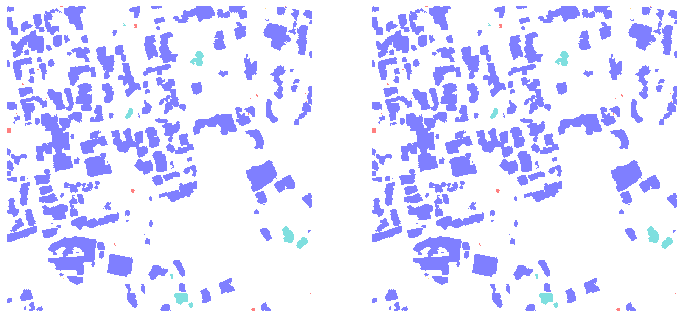

In [134]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))
open_mask(path_local).show(axs[0], cmap=CMAP, vmax=len(CMAP.colors) - 1)
open_mask(path_damg).show(axs[1], cmap=CMAP, vmax=len(CMAP.colors) - 1)

### Save submission png files into tarball

In [136]:
#! tar czvf {str(path_results)}.tar.gz {str(path_results)}


inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00536_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00313_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00142_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00376_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00919_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00111_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00065_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00620_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00315_predict

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00237_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00883_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00383_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00652_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00895_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00139_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00565_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00457_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00123_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_res

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00255_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00054_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00142_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00669_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00738_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00620_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00621_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00802_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00653_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00044_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00461_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00753_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00301_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00563_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00544_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00163_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00799_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00240_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00539_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00428_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00437_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00455_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00207_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00239_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00660_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00930_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00520_prediction.png
inference_results_best_model_damg_nsample94

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00648_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00447_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00784_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00675_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00506_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00582_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00703_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00078_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00911_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00894_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00733_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00699_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00041_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00901_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00574_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00108_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00623_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00797_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00191_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00909_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00670_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00593_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00531_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00896_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00107_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00602_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00824_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00585_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00546_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00906_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00319_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00446_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00920_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00158_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00653_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00826_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00375_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00498_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00628_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00905_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00760_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00236_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00260_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00250_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00098_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs

inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00591_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00654_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00554_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00651_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00583_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00878_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00336_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_damage_00665_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_localization_00902_prediction.png
inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152/test_

In [137]:
! du -hs inference_results*

18M	inference_results
12M	inference_results.tar.gz
17M	inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152
11M	inference_results_best_model_damg_nsample94313_sz299_bs32_resnet152.tar.gz
17M	inference_results_dcedf650b7
11M	inference_results_dcedf650b7.tar.gz
17M	inference_results_stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth
11M	inference_results_stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth.tar.gz
17M	inference_results_stage2_last_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth
11M	inference_results_stage2_last_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth.tar.gz


# - fin

In [138]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
